In [1]:
import os, numpy as np
from re import findall
from json import loads
from acconeer.exptool import utils, clients, configs
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class AcconeerSensorDataCollection:

    '''
    Creates a sensor object and its helper functions:
    • Load sensor configs from a json file
    • Connect to the Acconeer Radar sensor via serial/socket
    • Obtain data via IQ mode and save it to a .npy file
    '''

    def __init__(self, method, Nframes, config_path='sensor_configs.json'):

        self.connection_state = False
        self.session_state = False
        self.method = method
        self.Nframes = Nframes
        self.__sensor_config = self.get_config(config_path)


    def get_config(self, config_path):

        '''
        Loads configs from an external json file

        IQServiceConfig
        mode .............................. IQ
        sensor ............................ [1]
        range_interval .................... [0.2, 0.8]
        profile ........................... PROFILE_2
        update_rate ....................... 30.0
        sampling_mode ..................... A
        repetition_mode ................... HOST_DRIVEN
        downsampling_factor ............... 1
        hw_accelerated_average_samples .... 10
        gain .............................. 0.5
        maximize_signal_attenuation ....... False
        noise_level_normalization ......... True
        depth_lowpass_cutoff_ratio ........ None
        tx_disable ........................ False
        power_save_mode ................... ACTIVE
        asynchronous_measurement .......... True
        '''

        try:
            with open(config_path, 'r') as f:
                ext_dict = loads(f.read())
            config = configs.IQServiceConfig()
            config.hw_accelerated_average_samples = ext_dict['HWAAS']
            config.gain = ext_dict['gain']
            config.power_save_mode = ext_dict['power_save_mode']
            config.profile = ext_dict['profile']
            config.range_interval =[ext_dict['range_min'], ext_dict['range_max']]
            config.update_rate = ext_dict['update_rate']
            print(f'>> Successfully loaded {config_path}')

        except Exception:
            print('>> File not found / invalid json file! Using default configs ...')
            config = configs.IQServiceConfig()

        return config


    def get_config_dict(self):

        return {
            'mode': self.__sensor_config.mode,
            'sensor': self.__sensor_config.sensor,
            'range_interval': self.__sensor_config.range_interval,
            'profile': self.__sensor_config.profile,
            'update_rate': self.__sensor_config.update_rate,
            'sampling_mode': self.__sensor_config.sampling_mode,
            'repetition_mode': self.__sensor_config.repetition_mode,
            'downsampling_factor': self.__sensor_config.downsampling_factor,
            'hw_accelerated_average_samples': self.__sensor_config.hw_accelerated_average_samples,
            'gain': self.__sensor_config.gain,
            'maximize_signal_attenuation': self.__sensor_config.maximize_signal_attenuation,
            'noise_level_normalization': self.__sensor_config.noise_level_normalization,
            'depth_lowpass_cutoff_ratio': self.__sensor_config.depth_lowpass_cutoff_ratio,
            'tx_disable': self.__sensor_config.tx_disable,
            'power_save_mode': self.__sensor_config.power_save_mode,
            'asynchronous_measurement': self.__sensor_config.asynchronous_measurement,
        }


    def autodetect_serial_port(self):

        return utils.autodetect_serial_port()


    def list_serial_ports(self):

        try:
            opsys = os.uname()
            in_wsl = 'microsoft' in opsys.release.lower() and 'linux' in opsys.sysname.lower()
        except Exception:
            in_wsl = False

        port_tag_tuples = utils.get_tagged_serial_ports()

        if not in_wsl and os.name == 'posix':
            ports = []
            for i, (port, tag) in enumerate(port_tag_tuples):
                tag_string = ''
                if tag:
                    select = i
                    tag_string = ' ({})'.format(tag)
                ports.append(port + tag_string)
        else:
            ports = [port for port, *_ in port_tag_tuples]

        try:
            if in_wsl:
                print('>> WSL detected. Limiting serial ports')
                ports_reduced = []
                for p in ports:
                    if int(findall(r'\d+', p)[0]) < 20:
                        ports_reduced.append(p)
                ports = ports_reduced
        except Exception:
            pass

        return ports


    def connect_sensor(self, port):

        if not self.connection_state:

            self.client = clients.UARTClient(port)
            self.client.squeeze = False

            try:
                info = self.client.connect()
                self.rss_version = info.get('version_str', None)
                print(f'>> Connection success! RSS v{self.rss_version}')
                self.connection_state = True
                
            except Exception:
                print('>> Could not connect to sensor, please check the physical connection / free up the port.')
            
    
    def disconnect_sensor(self, verbose=True):

        if self.connection_state:
            try:
                if not self.session_state:
                    self.stop_session(verbose=False)
                self.client.disconnect()
                print('>> Client disconnected!')
                self.connection_state = False
            except Exception:
                pass
        
        elif verbose:
            print('>> Disconnect failed, no active connection found!')


    def check_connection_state(self):

        if self.connection_state:
            return True
        else:
            print('>> Connection not established with client. Please run connect_sensor()')
            return False


    def start_session(self):

        if not self.check_connection_state(): return

        if not self.session_state:
            
            try:
                self.session_info = self.client.setup_session(self.__sensor_config)
                self.client.start_session()
                self.session_state = True
                print('>> Session started!')
                self.depths = utils.get_range_depths(self.__sensor_config, self.session_info)
                self.Ndepths = self.depths.size
            except Exception:
                print('>> Session failed to start!')


    def stop_session(self, verbose=True):
        
        if self.session_state:
            try:
                self.client.stop_session()
                self.session_state = False
                print('>> Active session stopped!')
            except Exception:
                pass

        elif verbose:
            print('>> Stop session failed, no active session found!')


    def __del__(self):

        self.stop_session(verbose=False)
        self.disconnect_sensor(verbose=False)


    def get_data(self):

        if not self.check_connection_state(): return
        self.data = np.zeros([self.Nframes, self.Ndepths], dtype='complex')
        for frame in range(self.Nframes):
            self.data[frame, :] = self.client.get_next()[1]
        
        return self.data

In [20]:
radar = AcconeerSensorDataCollection(method='serial', Nframes=512, config_path='sensor_configs.json')
port = radar.autodetect_serial_port()
radar.connect_sensor(port)
radar.start_session()

>> Successfully loaded sensor_configs.json
>> Active session stopped!
>> Client disconnected!
Autodetected single available serial port on COM3

>> Connection success! RSS v2.8.2


data rate might be too high


>> Session started!


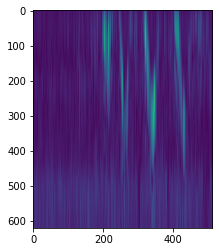

In [21]:
plt.imshow(np.abs(radar.get_data()).T);

In [13]:
# radar.disconnect_sensor()